# Sprawozdanie - MOwNiT - laboratorium 9., zadanie 1.

#### Autor: Jakub Psarski

## Analiza obrazów

- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz przykładowego reprezentanta grupy - wytnij z dużego zdjęcia wzorzec obiektu, np. literę e lub charakterystyczny fragment ryby z ławicy (imcrop).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem, a całym obrazem.
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

### Importowanie potrzebnych bibliotek

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.feature import peak_local_max

### 2. Główne funkcje

- `analyze_fourier_transform`: Funkcja przeprowadza transformatę Fouriera na obrazie wejściowym. Zwraca zlogarytmowany moduł oraz fazę transformaty, co pozwala na analizę częstotliwościową obrazu.

- `detect_pattern_correlation`: Funkcja oblicza korelację między obrazem a wzorcem przy użyciu transformaty Fouriera. Poprzez przekształcenie obrazów do domeny częstotliwości, obliczenie iloczynu i odwrotną transformatę, uzyskujemy mapę korelacji wskazującą na podobieństwo wzorca w różnych miejscach obrazu.

- `find_pattern_locations`: Funkcja lokalizuje miejsca wystąpienia wzorca na mapie korelacji poprzez wykrywanie lokalnych maksimów. Wykorzystuje wartość progową opartą na percentylu oraz minimalną odległość między wykrytymi wzorcami, aby zapewnić wiarygodną detekcję.

In [2]:
def analyze_fourier_transform(image):
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)

    magnitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)

    magnitude_log = np.log(magnitude + 1)

    return magnitude_log, phase


def detect_pattern_correlation(image, pattern):
    ph, pw = pattern.shape

    pattern_rotated = np.rot90(pattern, 2)

    pattern_padded = np.zeros_like(image)
    pattern_padded[:ph, :pw] = pattern_rotated

    fft_image = np.fft.fft2(image)
    fft_pattern = np.fft.fft2(pattern_padded)

    correlation_fft = fft_image * fft_pattern

    correlation = np.real(np.fft.ifft2(correlation_fft))

    return correlation


def find_pattern_locations(correlation, threshold_percentile=95, min_distance=10):
    threshold = np.percentile(correlation, threshold_percentile)

    peaks = peak_local_max(
        correlation, min_distance=min_distance, threshold_abs=threshold
    )

    return list(peaks), threshold

### 2. Funkcje pomocnicze

- `load_and_preprocess_image`: Funkcja ładuje obraz z pliku na podstawie podanej ścieżki, opcjonalnie odwraca kolory i zwraca go jako `np.ndarray`.

- `visualize_fourier_transformation`, `visualize_results` - wizualizacja wyników transformacji oraz dopasowania wzorca.

In [3]:
def load_and_preprocess_image(image_path, invert_colors=False):
    try:
        img = Image.open(image_path)

        if img.mode != "L":
            img = img.convert("L")

        img_array = np.array(img, dtype=np.float64)

        if invert_colors:
            img_array = 255 - img_array

        img_array = img_array / 255.0

        return img_array
    except Exception as e:
        print(f"Error while processing {image_path}: {e}")
        return None


def visualize_fourier_transformation(magnitude_log, phase, image, title=""):
    fig, axes = plt.subplots(3, 1, figsize=(9, 14))
    fig.suptitle(f"{title} - Fourier transformation analysis", fontsize=16)

    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original image")
    axes[0].axis("off")

    axes[1].imshow(magnitude_log, cmap="gray")
    axes[1].set_title("Magnitude (log scale)")
    axes[1].axis("off")

    axes[2].imshow(phase, cmap="hsv")
    axes[2].set_title("Phase")
    axes[2].axis("off")

    plt.show()


def visualize_results(
    original_image, correlation, locations, title_prefix="", pattern_shape=None
):
    fig1, axes = plt.subplots(3, 1, figsize=(9, 14))
    fig1.suptitle(f"{title_prefix} - Pattern detection", fontsize=16)

    axes[0].imshow(original_image, cmap="gray")
    if locations and pattern_shape is not None:
        ph, pw = pattern_shape
        for y, x in locations:
            rect = plt.Rectangle(
                (x - pw, y - ph), pw, ph, linewidth=1, edgecolor="r", facecolor="none"
            )
            axes[0].add_patch(rect)
    axes[0].set_title(f"Detected patterns ({len(locations)} found)")
    axes[0].axis("off")

    axes[1].imshow(correlation, cmap="hot")
    axes[1].set_title("Correlation map")
    axes[1].axis("off")

    axes[2].hist(correlation.flatten(), bins=100, alpha=0.7)
    axes[2].set_title("Correlation histogram")
    axes[2].set_xlabel("Correlation value")
    axes[2].set_ylabel("Frequency")

    for ax in axes[:2]:
        pos = ax.get_position()
        ax.set_position([pos.x0-0.05, pos.y0, pos.width, pos.height])

    plt.show()

    fig2 = plt.figure(figsize=(10, 10))
    fig2.suptitle(f"{title_prefix} - 3D correlation surface", fontsize=16)
    
    ax_3d = fig2.add_subplot(111, projection="3d")
    y_3d, x_3d = np.mgrid[0 : correlation.shape[0] : 10, 0 : correlation.shape[1] : 10]
    ax_3d.plot_surface(x_3d, y_3d, correlation[::10, ::10], cmap="hot", alpha=0.7)
    
    plt.tight_layout(pad=3.0)
    plt.show()

### 3. Wyniki

Image analysis: Text (galia)


1. Fourier transformation analysis


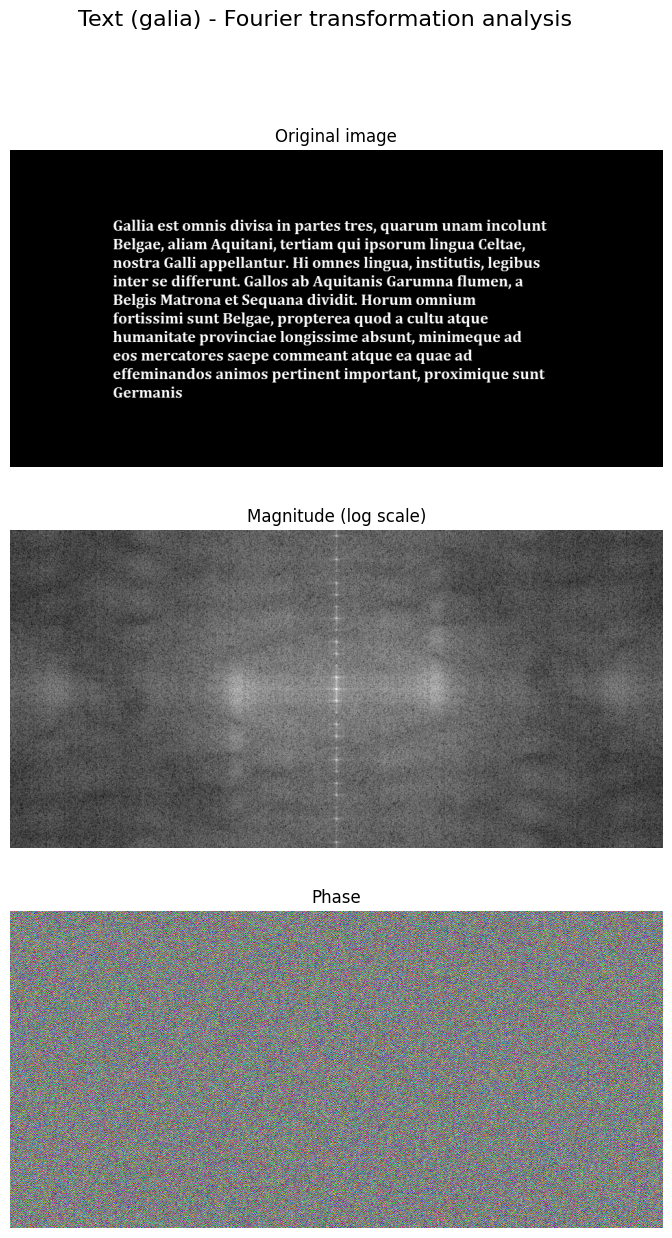


2. Pattern detection

Detection threshold: 48.4117
Pattern occurrences: 43


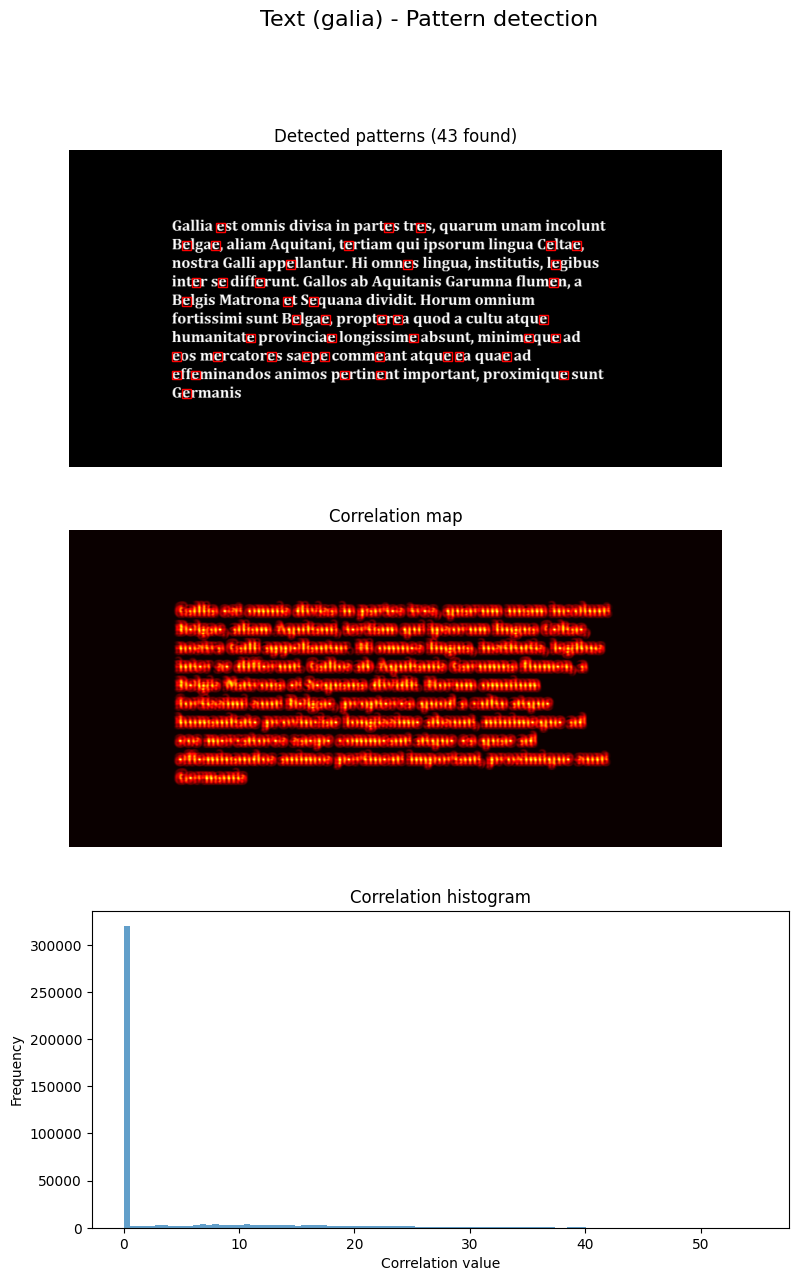

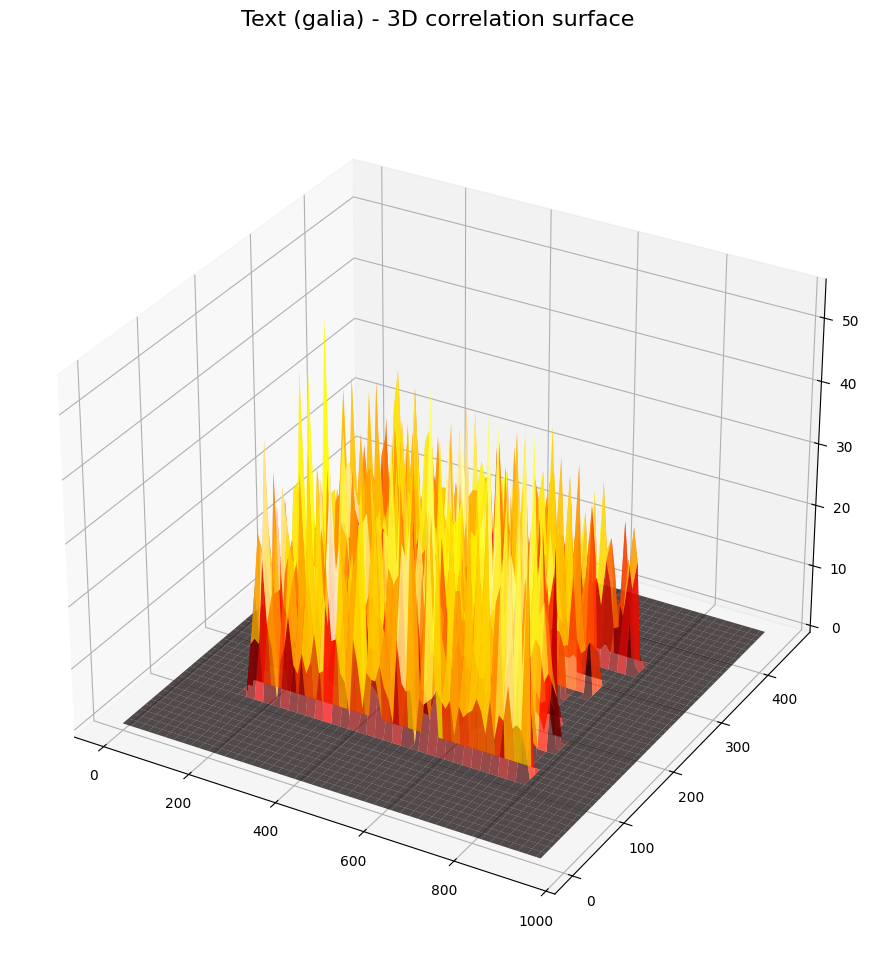


Correlation statistics:
  Maximum value: 54.9414
  Minimum value: 0.0000
  Average value: 4.1186
  Standard deviation: 8.2718


Image analysis: Fish school


1. Fourier transformation analysis


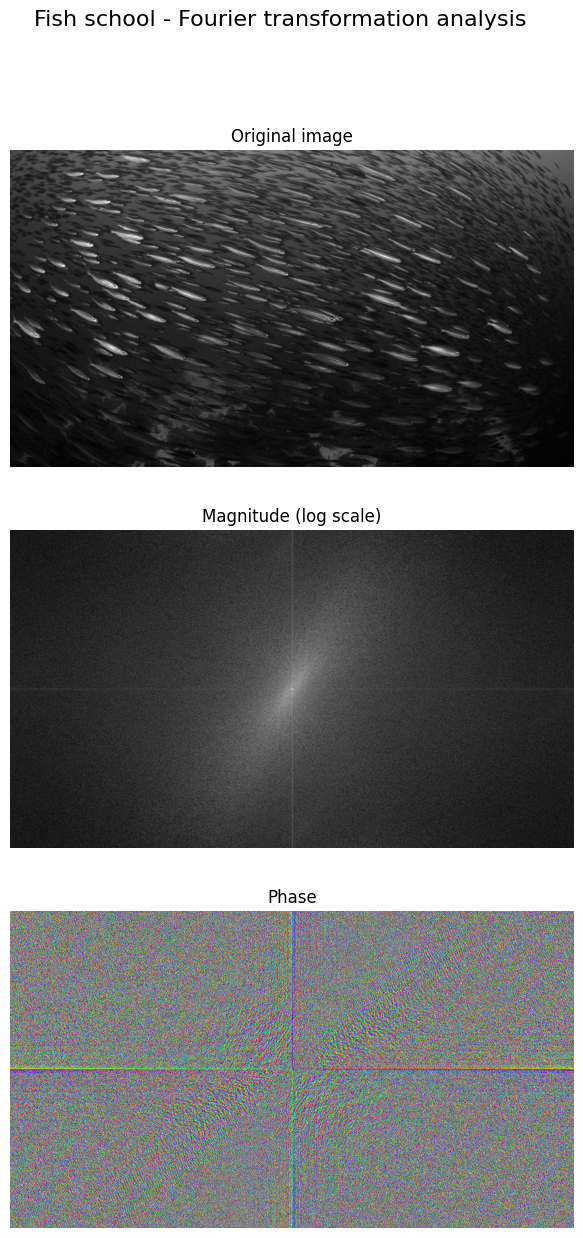


2. Pattern detection

Detection threshold: 84.3135
Pattern occurrences: 130


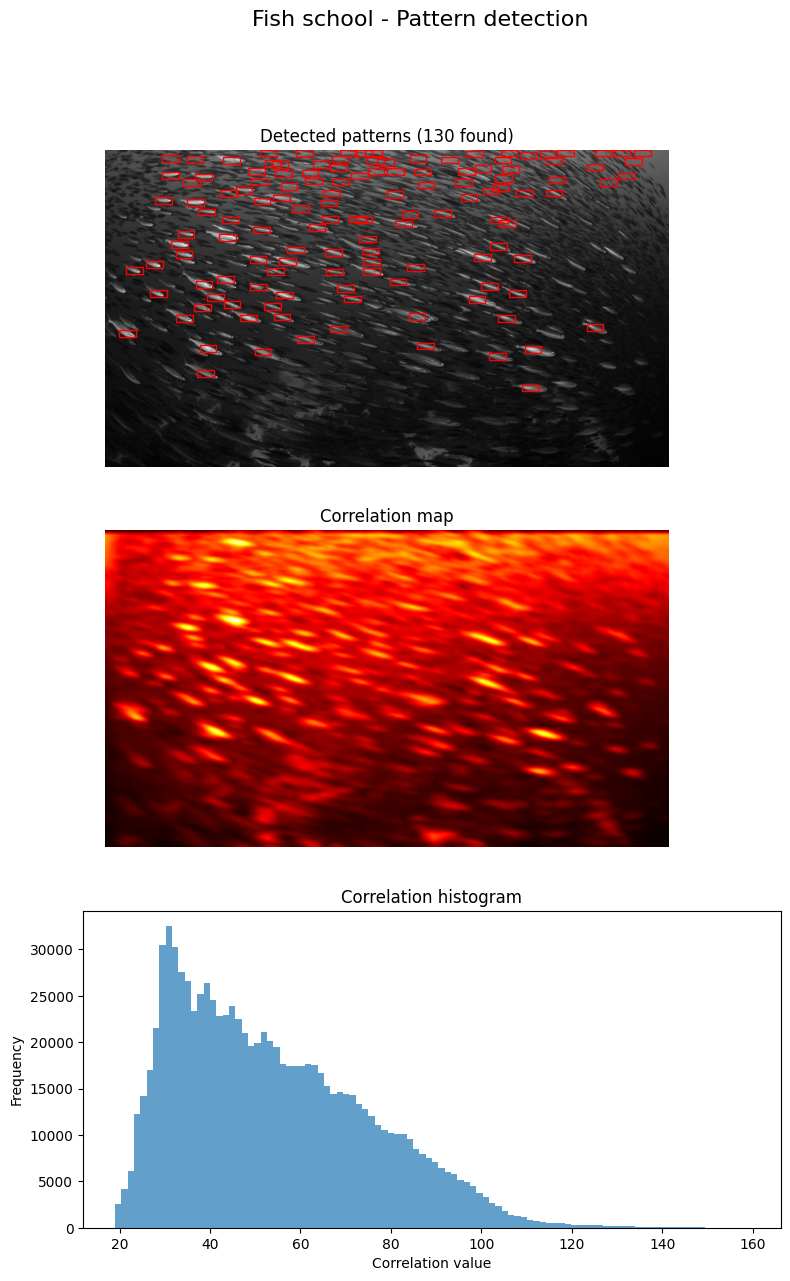

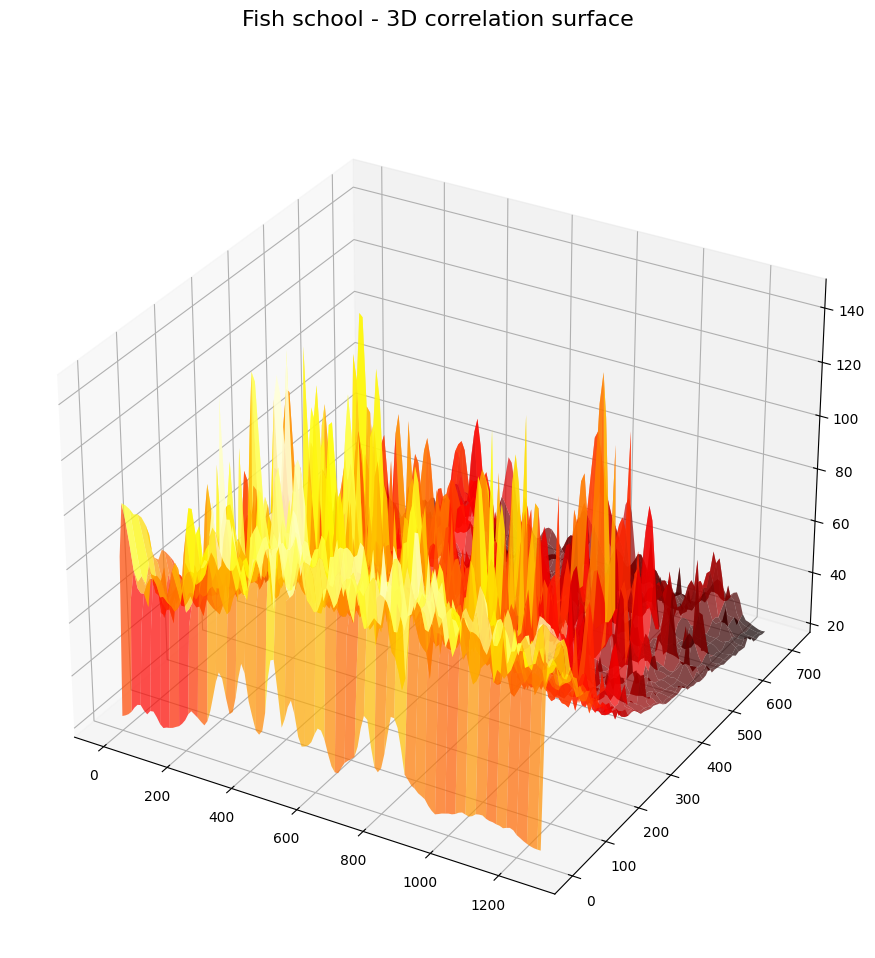


Correlation statistics:
  Maximum value: 159.1409
  Minimum value: 18.9682
  Average value: 53.7258
  Standard deviation: 21.1974




In [4]:
IMG_PATH = os.path.join(os.path.dirname(os.path.abspath("__file__")), "image_analysis", "images")
os.makedirs(IMG_PATH, exist_ok=True)

datasets = [
    {
        "name": "Text (galia)",
        "image_path": os.path.join(IMG_PATH, "galia.png"),
        "pattern_path": os.path.join(IMG_PATH, "galia_e.png"),
        "invert_colors": True,
        "threshold_percentile": 99.9902,  # best threshold value (found by trial and error)
    },  # which detects all 'e' characters without false positives
    {
        "name": "Fish school",
        "image_path": os.path.join(IMG_PATH, "school.jpg"),
        "pattern_path": os.path.join(IMG_PATH, "fish1.png"),
        "invert_colors": False,
        "threshold_percentile": 90,
    },
]

for dataset in datasets:
    print(f"Image analysis: {dataset['name']}\n")

    main_image = load_and_preprocess_image(
        dataset["image_path"], dataset["invert_colors"]
    )
    pattern_image = load_and_preprocess_image(
        dataset["pattern_path"], dataset["invert_colors"]
    )

    if main_image is None or pattern_image is None:
        print(f"Error reading images for dataset {dataset['name']}")
        continue

    print("\n1. Fourier transformation analysis")
    magnitude_log, phase = analyze_fourier_transform(main_image)
    visualize_fourier_transformation(
        magnitude_log, phase, main_image, dataset["name"]
    )

    print("\n2. Pattern detection")
    correlation = np.abs(detect_pattern_correlation(main_image, pattern_image))

    locations, threshold = find_pattern_locations(
        correlation, threshold_percentile=dataset["threshold_percentile"]
    )

    print(f"\nDetection threshold: {threshold:.4f}")
    print(f"Pattern occurrences: {len(locations)}")

    visualize_results(
        main_image,
        correlation,
        locations,
        dataset["name"],
        pattern_shape=pattern_image.shape,
    )

    print("\nCorrelation statistics:")
    print(f"  Maximum value: {np.max(correlation):.4f}")
    print(f"  Minimum value: {np.min(correlation):.4f}")
    print(f"  Average value: {np.mean(correlation):.4f}")
    print(f"  Standard deviation: {np.std(correlation):.4f}")

    print(f"\n{'='*40}\n")